In [280]:
import numpy as np
import itertools
from pathlib import Path
%matplotlib inline
import matplotlib.pyplot as plt
import sys
sys.path.append("../code/")
from dataloader import get_train_test
import pandas as pd

In [498]:
fold_num = 0
dataset = 1

In [499]:
# load best parameters for rnn-individual and rnn-tree
best_rnn_individual = np.load("../code/baseline/result/rnn-individual-param-{}.npy".format(dataset)).item()
best_rnn_tree = np.load("../code/baseline/result/rnn-tree-param-{}.npy".format(dataset)).item()

In [500]:
# cnn-individual&cnn-tree best parameters
best_cnn_individual = np.load("../code/baseline/result/cnn-individual-param-{}.npy".format(dataset)).item()
best_cnn_tree = np.load("../code/baseline/result/cnn-tree-param-{}.npy".format(dataset)).item()

In [501]:
# get prediction for rnn individual
rnn_individual_pred = {}
rnn_individual_error = {}
for appliance in ['hvac', 'fridge', 'dr', 'dw', 'mw']:
    cell_type = best_rnn_individual[appliance][fold_num]['cell_type']
    hidden_size = best_rnn_individual[appliance][fold_num]['hidden_size']
    num_layers = best_rnn_individual[appliance][fold_num]['num_layers']
    lr = best_rnn_individual[appliance][fold_num]['lr']
    iters = best_rnn_individual[appliance][fold_num]['iters']
    bidirectional = best_rnn_individual[appliance][fold_num]['bidirectional']
    
    directory = "../code/baseline/rnn-tree/{}/{}/{}/{}/{}/{}/{}/3000/0.0/".format(dataset, fold_num, cell_type,
                                                                                                hidden_size,
                                                                                                num_layers,
                                                                                                bidirectional,
                                                                                                lr)
    filename = "test-pred-{}-{}-{}-{}-{}-{}-{}-3000-0.0-[\'{}\'].npy".format(fold_num, dataset, cell_type, hidden_size, num_layers,
                                                                             bidirectional, lr, appliance)
    
    full_path = directory + filename
    rnn_individual_pred[appliance] = np.asarray(np.load(full_path).item()[iters]).reshape(-1, 1, 112, 24)
    filename = "test-error-{}-{}-{}-{}-{}-{}-{}-3000-0.0-[\'{}\'].npy".format(fold_num, dataset, cell_type, hidden_size, num_layers,
                                                                             bidirectional, lr, appliance)
    full_path = directory + filename
    rnn_individual_error[appliance] = np.load(full_path).item()[iters][appliance]
    

In [502]:
# get prediction for rnn tree
rnn_tree_pred = {}
rnn_tree_error = {}

cell_type = best_rnn_tree[fold_num]['cell_type']
hidden_size = best_rnn_tree[fold_num]['hidden_size']
num_layers = best_rnn_tree[fold_num]['num_layers']
lr = best_rnn_tree[fold_num]['lr']
iters = best_rnn_tree[fold_num]['iters']
bidirectional = best_rnn_tree[fold_num]['bidirectional']
order = best_rnn_tree[fold_num]['order']
directory = "../code/baseline/rnn-tree/{}/{}/{}/{}/{}/{}/{}/3000/0.0/".format(dataset, fold_num, cell_type,
                                                                                            hidden_size,
                                                                                            num_layers,
                                                                                            bidirectional,
                                                                                            float(lr))
filename = "test-pred-{}-{}-{}-{}-{}-{}-{}-3000-0.0-[\'{}\'].npy".format(fold_num, dataset, cell_type, hidden_size, num_layers,
                                                                         bidirectional, float(lr), str(order)[2:-2])

full_path = directory + filename
rnn_pred = np.asarray(np.load(full_path).item()[iters])
filename = "test-error-{}-{}-{}-{}-{}-{}-{}-3000-0.0-[\'{}\'].npy".format(fold_num, dataset, cell_type, hidden_size, num_layers,
                                                                         bidirectional, float(lr), str(order)[2:-2])
full_path = directory + filename
rnn_tree_error= np.load(full_path).item()[iters] 

for idx, appliance in enumerate(order):
    print(idx, appliance)
    rnn_tree_pred[appliance] = rnn_pred[idx].reshape(-1, 1, 112,24)

0 fridge
1 hvac
2 dw
3 dr
4 mw


In [503]:
# get prediction for cnn individual
cnn_individual_pred = {}
cnn_individual_error = {}
for appliance in ['hvac', 'fridge', 'dr', 'dw', 'mw']:
    iters= best_cnn_individual[appliance][fold_num]['iters']
    lr = best_cnn_individual[appliance][fold_num]['lr']
    
    directory = "../code/baseline/cnn-individual/{}/{}/{}/{}/".format(dataset, fold_num, lr, iters)
    filename = "test-pred-{}.npy".format(appliance)
    full_path = directory + filename
    cnn_individual_pred[appliance] = np.load(full_path)
    
    filename = "test-loss-{}.npy".format(appliance)
    full_path = directory + filename
    cnn_individual_error[appliance] = np.load(full_path).item().cpu().data.numpy()[0]
    

In [504]:
# get prediction for cnn tree
iters = best_rnn_tree[fold_num]['iters']
order = best_rnn_tree[fold_num]['order']


cnn_pred = np.load("../code/baseline/cnn-tree/{}/{}/0.01/20000/0.0/test-pred-[\'{}\'].npy".format(dataset, fold_num, str(order)[2:-2])).item()
cnn_tree_loss = np.load("../code/baseline/cnn-tree/{}/{}/0.01/20000/0.0/test-error-[\'{}\'].npy".format(dataset, fold_num, str(order)[2:-2])).item()[iters]
# order = ['dw', 'dr', 'hvac', 'fridge', 'mw']
cnn_tree_pred = {}
for idx, appliance in enumerate(order):
    cnn_tree_pred[appliance] = cnn_pred[iters][idx].reshape(-1, 1, 112,24)

In [505]:
# get prediction for cnn-rnn tree
from sklearn.metrics import mean_absolute_error
cnn_rnn_test_fold = np.load("../code/test_pred.npy")
cnn_rnn_gt_fold = np.load("../code/test_gt.npy")
cnn_rnn_error = {}
cnn_rnn_pred = {}
gt = {}
for appliance_num, appliance in enumerate(['fridge', 'dr', 'hvac', 'dw', 'mw']):
    cnn_rnn_error[appliance] = mean_absolute_error(cnn_rnn_test_fold[appliance_num], cnn_rnn_gt_fold[appliance_num])
    cnn_rnn_pred[appliance] = cnn_rnn_test_fold[appliance_num].reshape(-1, 1, 112, 24)
    gt[appliance] = cnn_rnn_gt_fold[appliance_num].reshape(-1, 1, 112, 24)

In [506]:
print(cnn_individual_error)
print(cnn_tree_loss)
print(rnn_individual_error)
print(rnn_tree_error)

{'hvac': 186.65683, 'fridge': 29.265575, 'dr': 37.524254, 'dw': 11.02479, 'mw': 7.3939905}
{'fridge': 30.568978197070603, 'hvac': 176.62601127726398, 'dw': 11.024308427146485, 'dr': 111.57235286515156, 'mw': 7.5865032680397606}
{'hvac': 112.15536943674897, 'fridge': 26.364538273818635, 'dr': 51.332113758065901, 'dw': 11.13229631636338, 'mw': 6.813213514919009}
{'fridge': 32.386288271646919, 'hvac': 90.562519457287365, 'dw': 11.031979601126308, 'dr': 49.031312089803237, 'mw': 8.9075847805505788}


In [507]:
pred = {}
pred['Individual RNN'] = rnn_individual_pred
pred['Tree RNN'] = rnn_tree_pred
pred['Individual CNN'] = cnn_individual_pred
pred['Tree CNN'] = cnn_tree_pred
# pred['Tree CNN-RNN'] = cnn_rnn_pred

In [508]:
error = {}
error['Individual RNN'] = rnn_individual_error
error['Tree RNN'] = rnn_tree_error
error['Individual CNN'] = cnn_individual_error
error['Tree CNN'] = cnn_tree_loss
# error['Tree CNN-RNN'] = cnn_rnn_error

In [509]:
pd.DataFrame(error).T

,dr,dw,fridge,hvac,mw
Individual CNN,37.524254,11.024790,29.265575,186.656830,7.393991
Individual RNN,51.332114,11.132296,26.364538,112.155369,6.813214
Tree CNN,111.572353,11.024308,30.568978,176.626011,7.586503
Tree RNN,49.031312,11.031980,32.386288,90.562519,8.907585


# Analysis on predictions

In [310]:
train, test = get_train_test(dataset, 5, 0)
test_aggregate = test[:, 0]

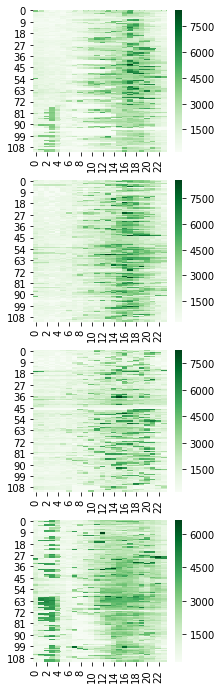

In [311]:
fig, axes = plt.subplots(nrows = 4, figsize=(3, 12))
ax = axes.flatten()
homes = [0, 4, 8, 12]
for i, home_id in enumerate(homes):
    sns.heatmap(test_aggregate[home_id], ax=ax[i], cmap='Greens', )
# ax[i*6+1].yaxis.set_ticklabels([])

In [312]:
import seaborn as sns

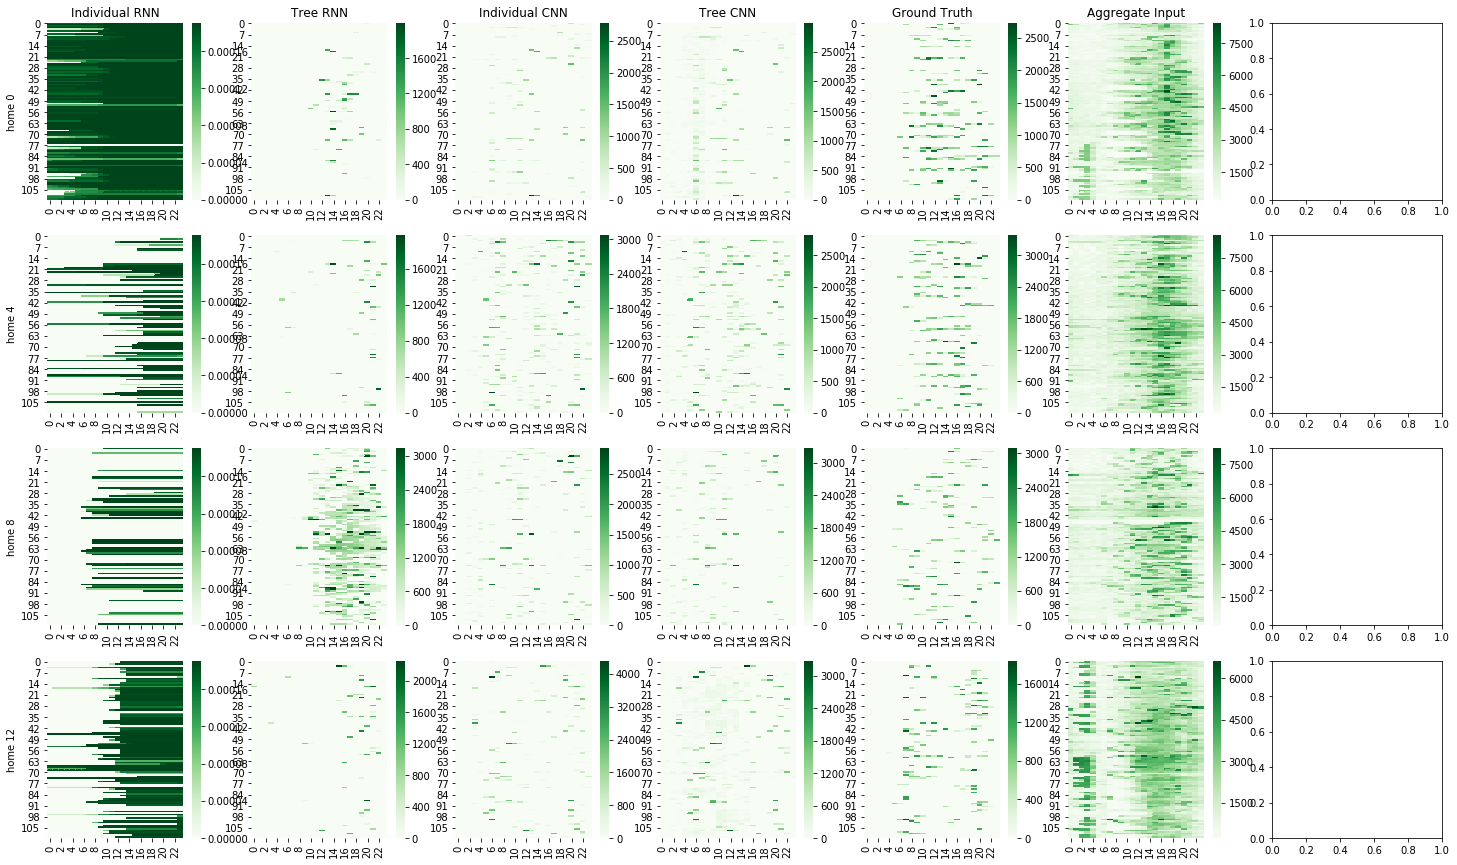

In [487]:
fig, axes = plt.subplots(ncols=7,nrows = 4, figsize=(25, 15))
ax = axes.flatten()
homes = [0, 4, 8, 12]
appliance = 'dr'

for i, home_id in enumerate(homes):
    for idx, method in enumerate(pred.keys()):
        sns.heatmap(pred[method][appliance][home_id][0], ax=ax[i*7 + idx], cmap='Greens')
        ax[idx].set_title(method)
    idx+=1
    sns.heatmap(gt[appliance][home_id][0], ax=ax[i*7 + idx], cmap='Greens')
    ax[idx].set_title("Ground Truth")
    idx+=1
    sns.heatmap(test_aggregate[home_id], ax=ax[i*7+idx], cmap='Greens')
    ax[idx].set_title("Aggregate Input")
for i in range(4):
    ax[i*7].set_ylabel("home {}".format(homes[i]))

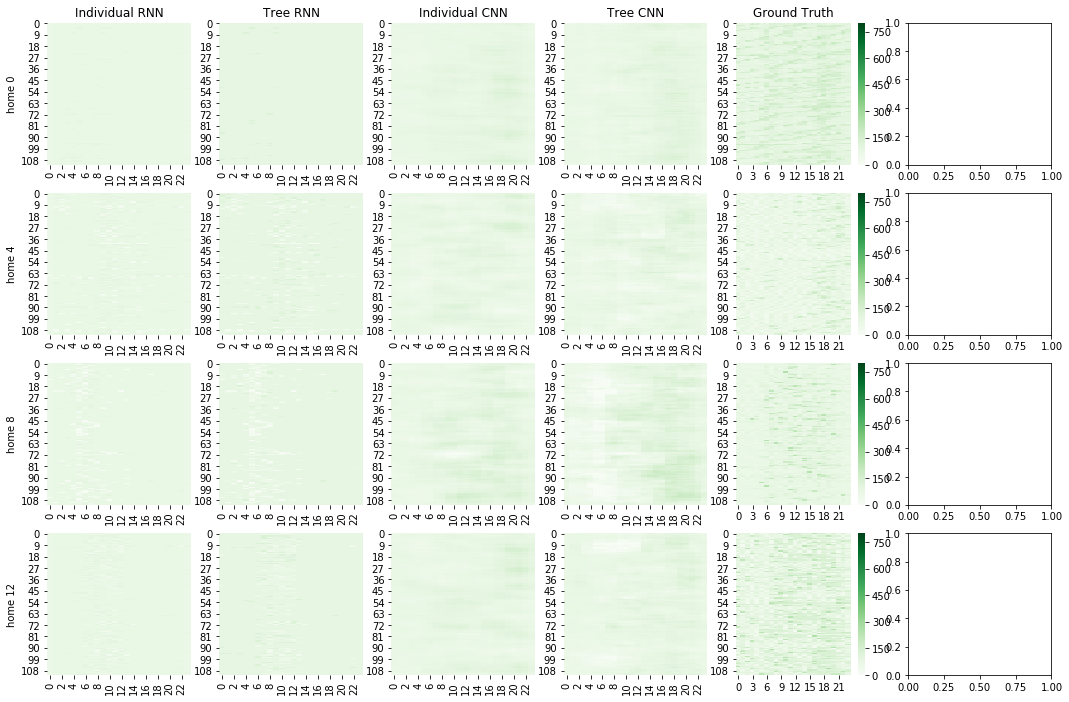

In [488]:
fig, axes = plt.subplots(ncols=6,nrows = 4, figsize=(18, 12))
ax = axes.flatten()
homes = [0, 4, 8, 12]
appliance = 'fridge'

for i, home_id in enumerate(homes):
    for idx, method in enumerate(pred.keys()):
        sns.heatmap(pred[method][appliance][home_id][0], ax=ax[i*6 + idx], cmap='Greens', vmin=0, vmax=800, cbar=False)
        ax[idx].set_title(method)
    idx+=1
    sns.heatmap(gt[appliance][home_id][0], ax=ax[i*6 + idx], cmap='Greens',vmin=0, vmax=800)
    ax[idx].set_title("Ground Truth")
for i in range(4):
    ax[i*6].set_ylabel("home {}".format(homes[i]))

# Raw Data Analysis

In [97]:
tensor = np.load("../2015-5appliances.numpy.npy")
tensor.shape

(68, 6, 112, 24)

In [159]:
appliance = 'mw'
dr_readings = tensor[:, 4]
dr_readings.shape

(68, 112, 24)

In [160]:
avg = {}
use_days = {}
interval = {}
for i in range(68):
    home_readings = dr_readings[i]
    avg[i] = []
    use_days[i] = []
    interval[i] = []
    for day in range(112):
        avg[i].append(dr_readings[i][day].mean())
        if dr_readings[i][day].mean() > 10:
            use_days[i].append(day)
            if len(use_days[i]) > 1:
                interval[i].append(use_days[i][-1] - use_days[i][-2])

(array([  2.76300000e+03,   6.80000000e+01,   1.60000000e+01,
          5.00000000e+00,   1.00000000e+00,   1.00000000e+00,
          0.00000000e+00,   0.00000000e+00,   0.00000000e+00,
          1.00000000e+00]),
 array([  1.,   8.,  15.,  22.,  29.,  36.,  43.,  50.,  57.,  64.,  71.]),
 <a list of 10 Patch objects>)

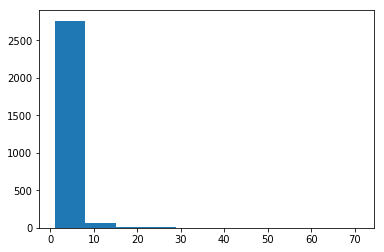

In [195]:
freq = []
for key, value in interval.items():
    freq.extend(value)
plt.hist(freq)

# non-zero predictions for each method

[36259, 745, 303, 160, 95, 40, 20, 6, 2, 2]
[-486.4793701171875, 165.09454345703125, 816.66845703125, 1468.2423706054688, 2119.8162841796875, 2771.3901977539062, 3422.964111328125, 4074.5380249023438, 4726.1119384765625, 5377.685852050781]


Text(0,0.5,'#')

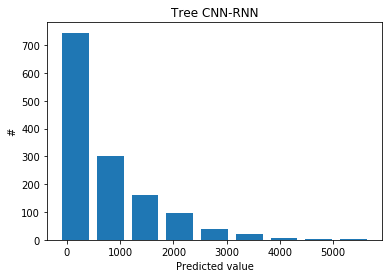

In [269]:
appliance = 'dr'
method = 'Tree CNN-RNN'
H, bins=np.histogram(pred[method][appliance].reshape(1, -1))
print(H.tolist())
print(bins[:-1].tolist())
plt.bar(bins[1:-1],H[1:], width=500)
plt.title(method)
plt.xlabel("Predicted value")
plt.ylabel("#")

In [193]:
for method in pred.keys():
    H, bins=np.histogram(pred[method][appliance].reshape(1, -1))

    print(method, H[0]/H.sum())

Individual RNN 0.0168739370748
Tree RNN 0.996784651361
Individual CNN 0.975021258503
Tree CNN 0.980575042517
Tree CNN-RNN 0.963515093537
